# Mid-Distance Performance Analysis

This is an analysis of the relationships between middle-distance events. I'm mostly interested in the 800, but the general idea is to be able to predict a certain race's outcome based on your performance in other events. Particularly, being able to predict your 800m time based off of your 400m and/or 1500m/mile time based off the current data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from glob import glob
from model import BivariateModel, MultivariateModel, plot_bivariate_eda

## TFRRS Data

The links in the following dictionary have been obtained by going to the TFRRS database archives, finding the men's 800m for the desired season/year, inspecting the table, and finding the src argument of the turbo-frame tag with id = 'list_data'. There are some patterns in the URLs, but the only consistent ones are the ones I've already automated. There are still random differences at times between divisions and between indoor and outdoor seasons.

[Example](https://tf.tfrrs.org/lists/3901/2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL):

> `<turbo-frame id="list_data" src="https://tf.tfrrs.org/list_data/3901?other_lists=`
> `https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying`
> `_FINAL&amp;limit=100&amp;event_type=53&amp;year=&amp;gender="> ... </turbo-frame>`

In [2]:
di_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3492?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3492%2F2021_2022_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3711?other_lists=https%3A%2F%2Fxc.tfrrs.org%2Flists%2F3711%2F2022_NCAA_Division_I_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3901?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F3901%2F2022_2023_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4044?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4044%2F2023_NCAA_Division_I_All_Schools_Rankings&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4364?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4364%2F2023_2024_NCAA_Div_I_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
}

def create_dx_dict(dict: dict, division: str) -> dict:
    '''Updates the values of the DI dictionary to correspond with DII and DIII URLs. There are still some inconsistencies, so some values will have to be manually fixed after the function.
    
    Parameters:
        dict (dict): the NCAA DI Dictionary of URLs
        division (str): 'II' or 'III' to match DII or DIII
        
    Returns:
        dx_dict (dict): a dict with updated values to match the corresponding NCAA division'''
    
    dx_dict = {}
    for season in dict:
        new_url = dict[season].replace('_I_', f'_{division}_')

        table_id = dict[season].split('?')[0][-4:]
        new_table_id = str(int(table_id) + len(division))
        new_url = new_url.replace(table_id, new_table_id)
        
        dx_dict[season] = new_url

    return dx_dict


dii_dict = create_dx_dict(di_dict, 'II')     
dii_dict['outdoor_2022'] = 'https://tf.tfrrs.org/list_data/3595?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F3595%2F2022_NCAA_Division_II_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m'

diii_dict = create_dx_dict(di_dict, 'III')
diii_dict['indoor_2024'] = 'https://tf.tfrrs.org/list_data/4366?other_lists=https%3A%2F%2Fupload.tfrrs.org%2Flists%2F4366%2F2023_2024_NCAA_Div_III_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m'

naia_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3495?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3495%2F2021_2022_NAIA_Indoor_Qualifying_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3596?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3596%2F2022_NAIA_Outdoor_Qualifying_List_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3904?other_lists=https%3A%2F%2Fwww.tfrrs.org%2Flists%2F3904%2F2022_2023_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4046?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F4046%2F2023_NAIA_Outdoor_Qualifying_FINAL&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4368?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4368%2F2023_2024_NAIA_Indoor_Qualifying_List_FINAL&limit=500&event_type=54&year=&gender=m',
}

njcaa_dict = {
    'indoor_2022': 'https://tf.tfrrs.org/list_data/3496?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3496%2F2021_2022_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2022': 'https://tf.tfrrs.org/list_data/3717?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F3717%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2023': 'https://tf.tfrrs.org/list_data/3905?other_lists=https%3A%2F%2Fmobile.tfrrs.org%2Flists%2F3905%2F2022_2023_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
    'outdoor_2023': 'https://tf.tfrrs.org/list_data/4201?other_lists=https%3A%2F%2Ftf.tfrrs.org%2Flists%2F4201%2FNJCAA_All_Schools_Outdoor_Performance_List&limit=500&event_type=12&year=&gender=m',
    'indoor_2024': 'https://tf.tfrrs.org/list_data/4367?other_lists=https%3A%2F%2Fm.tfrrs.org%2Flists%2F4367%2F2023_2024_NJCAA_Indoor_Qualifying_List&limit=500&event_type=54&year=&gender=m',
}

### 800m and 400m

In [3]:
from scrape_tfrrs import TFRRSScraper

tfrrs_400 = TFRRSScraper(400)
if not glob(f'data/tfrrs*{tfrrs_400.other_event}.csv'):
    di_tfrrs_400 = tfrrs_400.download_seasons(di_dict, division='di')
    dii_tfrrs_400 = tfrrs_400.download_seasons(dii_dict, division='dii')
    diii_tfrrs_400 = tfrrs_400.download_seasons(diii_dict, division='diii')
    naia_tfrrs_400 = tfrrs_400.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs_400 = tfrrs_400.download_seasons(njcaa_dict, division='njcaa')
    df_tfrrs_400 = tfrrs_400.merge_tfrrs_data()
else:
    print(f'[INFO] TFRRS {tfrrs_400.other_event}m data found in data directory')
    df_tfrrs_400 = tfrrs_400.merge_tfrrs_data()

[INFO] TFRRS 400m data found in data directory


<Axes: title={'center': '400m vs 800m\nn=3,285'}, xlabel='time_400', ylabel='time_800'>

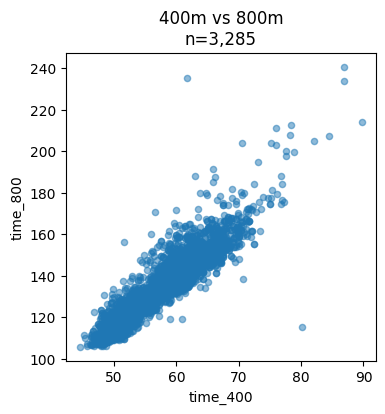

In [4]:
df_tfrrs_400.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'400m vs 800m\nn={len(df_tfrrs_400):,}'
)

### 800m and 1500m

In [5]:
tfrrs_1500 = TFRRSScraper(1500)
if not glob(f'data/tfrrs*{tfrrs_1500.other_event}.csv'):
    di_tfrrs_1500 = tfrrs_1500.download_seasons(di_dict, division='di')
    dii_tfrrs_1500 = tfrrs_1500.download_seasons(dii_dict, division='dii')
    diii_tfrrs_1500 = tfrrs_1500.download_seasons(diii_dict, division='diii')
    naia_tfrrs_1500 = tfrrs_1500.download_seasons(naia_dict, division='naia')
    njcaa_tfrrs_1500 = tfrrs_1500.download_seasons(njcaa_dict, division='njcaa')
    df_tfrrs_1500 = tfrrs_1500.merge_tfrrs_data()
else:
    print(f'[INFO] TFRRS {tfrrs_1500.other_event}m data found in data directory')
    df_tfrrs_1500 = tfrrs_1500.merge_tfrrs_data()

[INFO] TFRRS 1500m data found in data directory


<Axes: title={'center': '1500m vs 800m\nn=10,030'}, xlabel='time_1500', ylabel='time_800'>

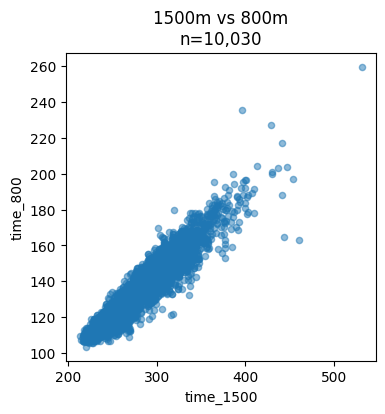

In [6]:
df_tfrrs_1500.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'1500m vs 800m\nn={len(df_tfrrs_1500):,}'
)

# df_tfrrs_1500.loc[(df_tfrrs_1500['time_800'] < 210) & 
#                   (df_tfrrs_1500['time_1500'] < 425)]

## MileSplit Data

I ran the MileSplitScraper in terminal because it was performing faster. Each complete run took about 3-4 hours.

In [7]:
if not glob('data/milesplit*.csv'):
    !python scrape_milesplit.py
else:
    print('[INFO] MileSplit data found in data directory')
    df_milesplit_400 = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024_400m.csv').drop_duplicates()
    df_milesplit_mile = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024_Mile.csv')
    df_milesplit_1600 = pd.read_csv('data/milesplit_indoor_2020-outdoor_2024_1600m.csv')


[INFO] MileSplit data found in data directory


### 800m vs 400m

<Axes: title={'center': '400m vs 800m\nn=6,097'}, xlabel='time_400', ylabel='time_800'>

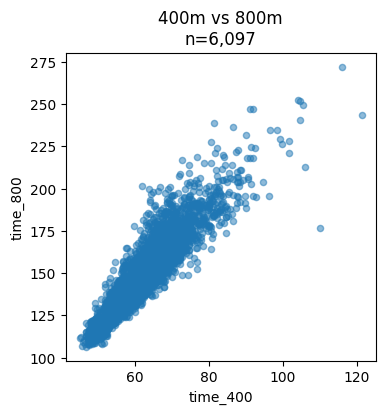

In [8]:
df_milesplit_400.plot(
    kind='scatter',
    x='time_400',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'400m vs 800m\nn={len(df_milesplit_400):,}'
)

### 800m vs 1500m converted from the 1600m or Mile

<Axes: title={'center': 'Mile -> 1500m vs 800m\nn=4,641'}, xlabel='time_1500', ylabel='time_800'>

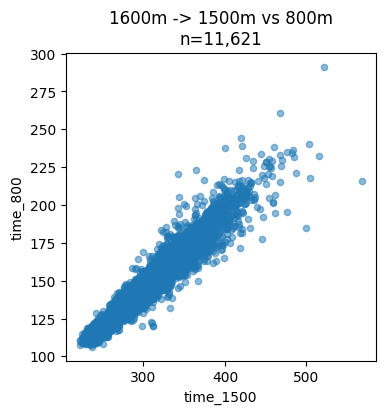

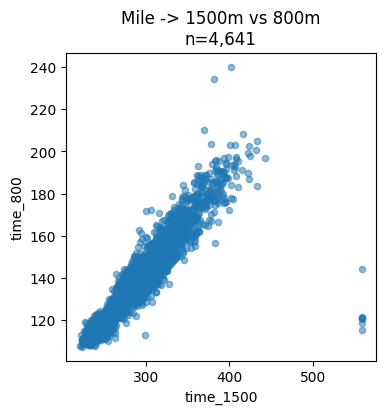

In [9]:
df_milesplit_1600.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'1600m -> 1500m vs 800m\nn={len(df_milesplit_1600):,}'
)

df_milesplit_mile.plot(
    kind='scatter',
    x='time_1500',
    y='time_800',
    figsize=(4,4),
    alpha = 0.5,
    title = f'Mile -> 1500m vs 800m\nn={len(df_milesplit_mile):,}'
)

## EDA and Data Cleaning

### Combined Data Sources

After doing some EDA, pretty apparent that Boosted Regression methods and/or analyzing the different sources separately will be necessary for better modelling of a wider range of speeds.

#### 800m vs 400m 

In [10]:
df_400 = pd.concat([df_tfrrs_400, df_milesplit_400])

##### Before Cleaning

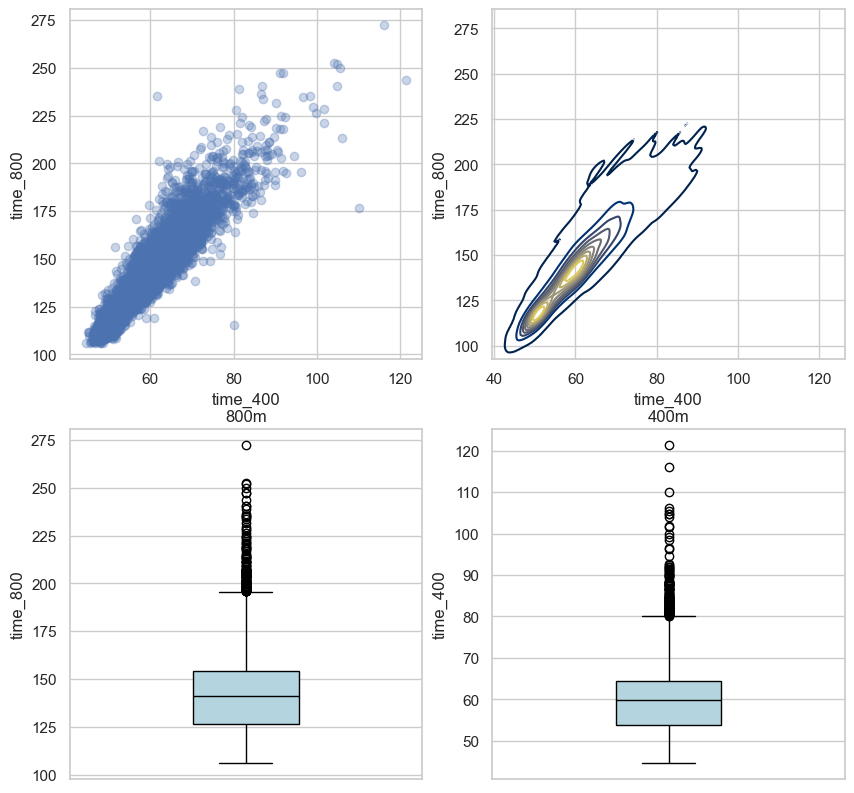

In [11]:
plot_bivariate_eda(df_400, 400)

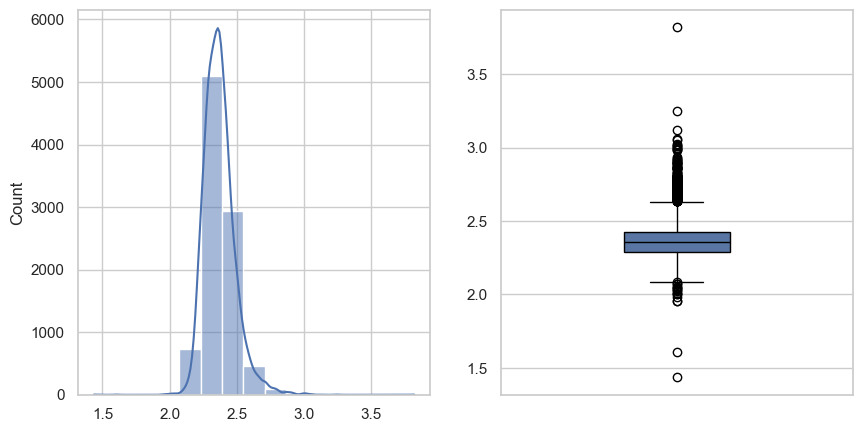

In [12]:
# Find metric to describe outliers
metric_400 = (df_400['time_800'] / df_400['time_400'])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(metric_400, 
             bins=int(np.ceil(np.log2(len(metric_400)) + 1)),
             kde=True)

plt.subplot(1,2,2)
sns.boxplot(y=metric_400.values, width=0.3, linecolor='black')
plt.show()

##### Cleaned Data

In [13]:
# Remove tails that aren't representative of the rest of the data
df_400 = df_400.loc[(df_400['time_800'] < 210) & (df_400['time_400'] < 90)]

# Remove unrealistic 400 vs 800 times/the new outlier metric
df_400 = df_400.loc[(df_400['time_800'] / df_400['time_400'] > 2) & (df_400['time_800'] / df_400['time_400'] < 2.75)]

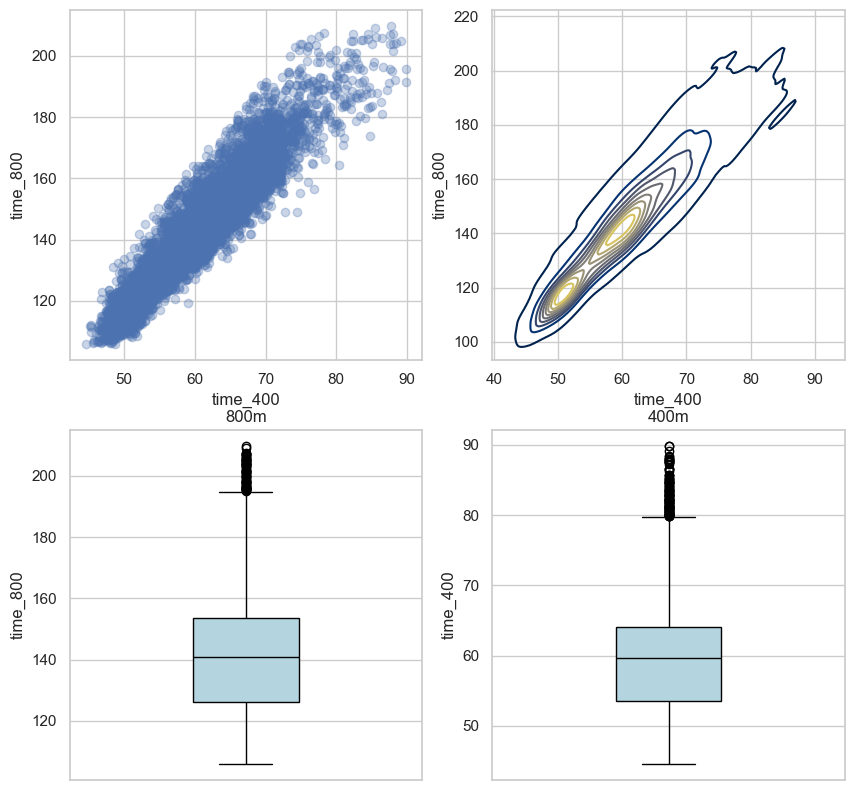

In [14]:
# Visualize
plot_bivariate_eda(df_400, 400)

##### Create Random Sample Groups

In [15]:
df_400['idx'] = range(len(df_400))
df_400.set_index('idx', inplace=True)

SAMPLE_SIZE = 40
N_GROUPS = int(np.ceil(len(df_400) / SAMPLE_SIZE))

df_400_shuffle = df_400.sample(frac=1, random_state=69420)
df_400_shuffle['sample_group'] = (list(range(N_GROUPS)) * SAMPLE_SIZE)[:len(df_400)]

df_400_sampled = df_400_shuffle.select_dtypes('number') \
    .groupby('sample_group') \
    .mean() \
    .round(2)

#### 800m vs 1500m

In [16]:
# Join Milesplit Data
df_milesplit_1500 = pd.merge(left=df_milesplit_1600, 
                             right=df_milesplit_mile,
                             on=['athlete_team', 'time_800', 'season'], 
                             how='left',
                             suffixes=['_1600', '_mile'])

df_milesplit_1500['time_1500'] = df_milesplit_1500[['time_1500_1600', 'time_1500_mile']].min(axis=1)
df_milesplit_1500.drop(columns=['time_1500_1600', 'time_1500_mile'], inplace=True)
df_milesplit_1500 = df_milesplit_1500[['athlete_team', 'time_800', 'time_1500', 'season']]

# Concatenate TFRRS and MileSplit
df_1500 = pd.concat([df_tfrrs_1500, df_milesplit_1500])

##### Before Cleaning

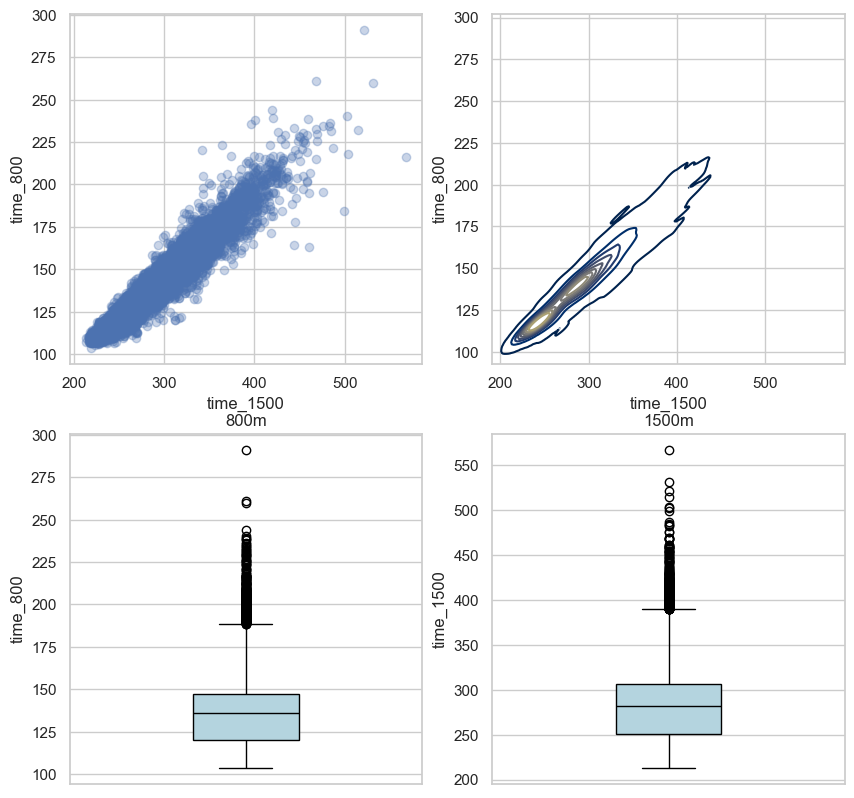

In [17]:
plot_bivariate_eda(df_1500, 1500)

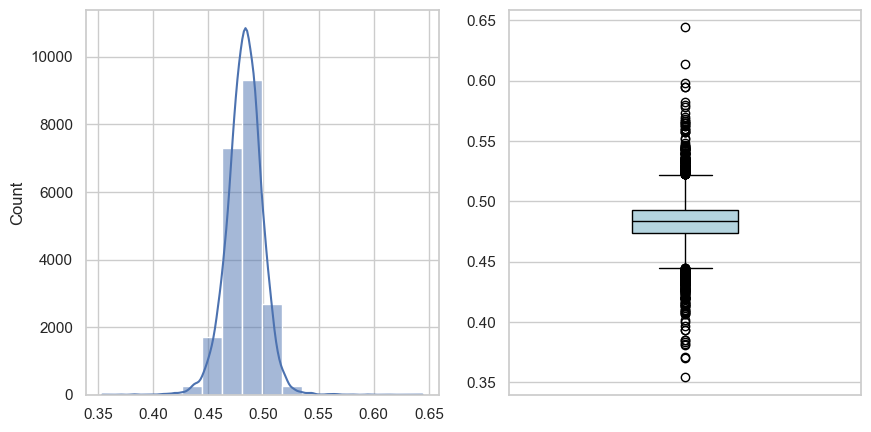

In [18]:
# Find metric to describe outliers
metric_1500 = (df_1500['time_800'] / df_1500['time_1500'])

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
sns.histplot(metric_1500, 
             bins=int(np.ceil(np.log2(len(metric_1500)) + 1)),
             kde=True)

plt.subplot(1,2,2)
sns.boxplot(y=metric_1500.values, width=0.3, color='lightblue', linecolor='black')
plt.show()

##### Cleaned Data

In [19]:
# Remove tails that aren't representative of the rest of the data
df_1500 = df_1500.loc[(df_1500['time_800'] < 190) & (df_1500['time_1500'] < 395)]

# Remove unrealistic 400 vs 800 times/the new outlier metric
df_1500 = df_1500.loc[(df_1500['time_800'] / df_1500['time_1500'] > 0.44) & (df_1500['time_800'] / df_1500['time_1500'] < 0.54)]

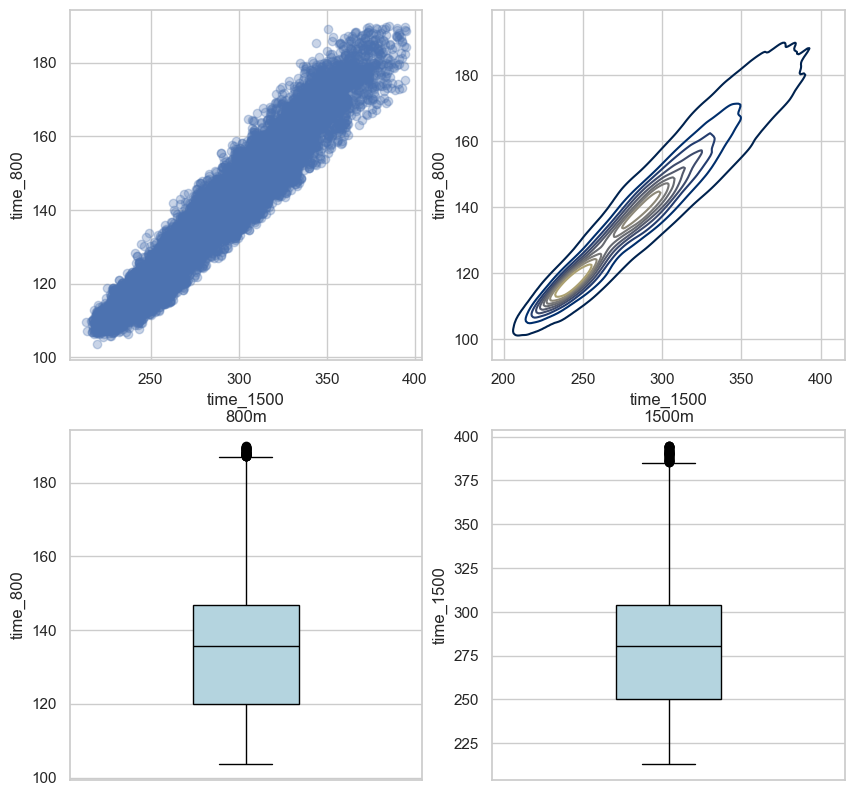

In [20]:
# Visualize
plot_bivariate_eda(df_1500, 1500)

##### Create Random Sample Groups

In [21]:
df_1500['idx'] = range(len(df_1500))
df_1500.set_index('idx', inplace=True)

SAMPLE_SIZE = 40
N_GROUPS = int(np.ceil(len(df_1500) / SAMPLE_SIZE))

df_1500_shuffle = df_1500.sample(frac=1, random_state=69420)
df_1500_shuffle['sample_group'] = (list(range(N_GROUPS)) * SAMPLE_SIZE)[:len(df_1500)]

df_1500_sampled = df_1500_shuffle.select_dtypes('number') \
    .groupby('sample_group') \
    .mean() \
    .round(2)

#### 800m vs 400m + 1500m

In [22]:
# Join all data
df_400_1500 = pd.merge(
    left=df_400, 
    right=df_1500,
    on=['athlete_team', 'time_800', 'season'], 
    how='left'
) \
    .dropna() \
    .drop_duplicates()

## Modelling

### Combined Data Sources

#### 800m vs 400m 

In [23]:
model_400 = BivariateModel(df_400_sampled, 400, 'ols')
model_400_robust = BivariateModel(df_400_sampled, 400, 'rlm')

##### OLS

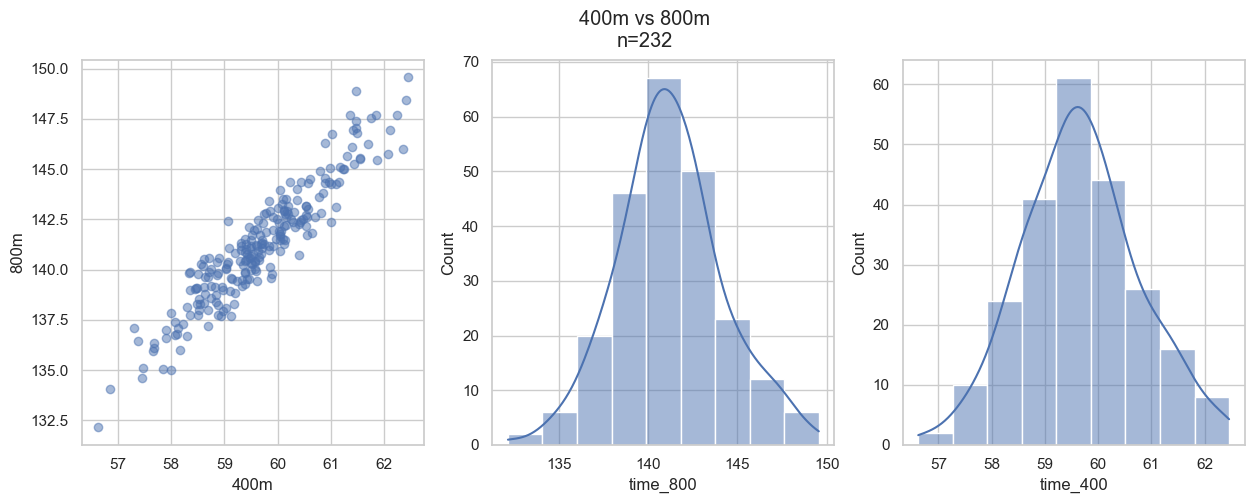

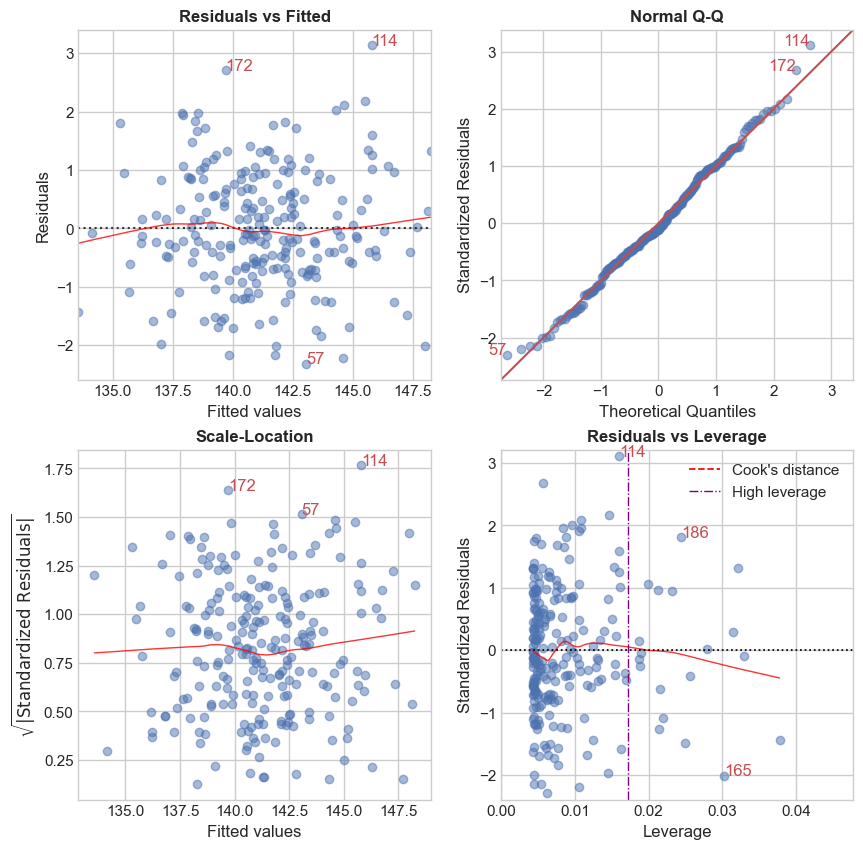

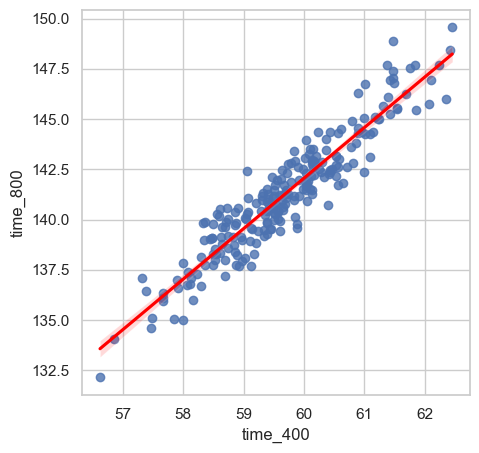

In [24]:
model_400.plot_dist()
model_400.check_assumptions()
model_400.plot_conf_int()

In [25]:
model_400.model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               time_800   R-squared:                       0.881
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     1710.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):          1.73e-108
Time:                        21:01:47   Log-Likelihood:                -331.23
No. Observations:                 232   AIC:                             666.5
Df Residuals:                     230   BIC:                             673.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.5560      3.623     -2.362      0.019     -15.694      -1.418
time_400       2.5103      0.061     41.357      0.000       2.391       2.630
==============================================================================
Omnibus:                        0.887   Durbin-Watson:                   2.097
Prob(Omnibus):                  0.642   Jarque-Bera (JB):                0.985
Skew:                           0.138   Prob(JB):                        0.611
Kurtosis:                       2.841   Cond. No.                     3.25e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.25e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Robust LM

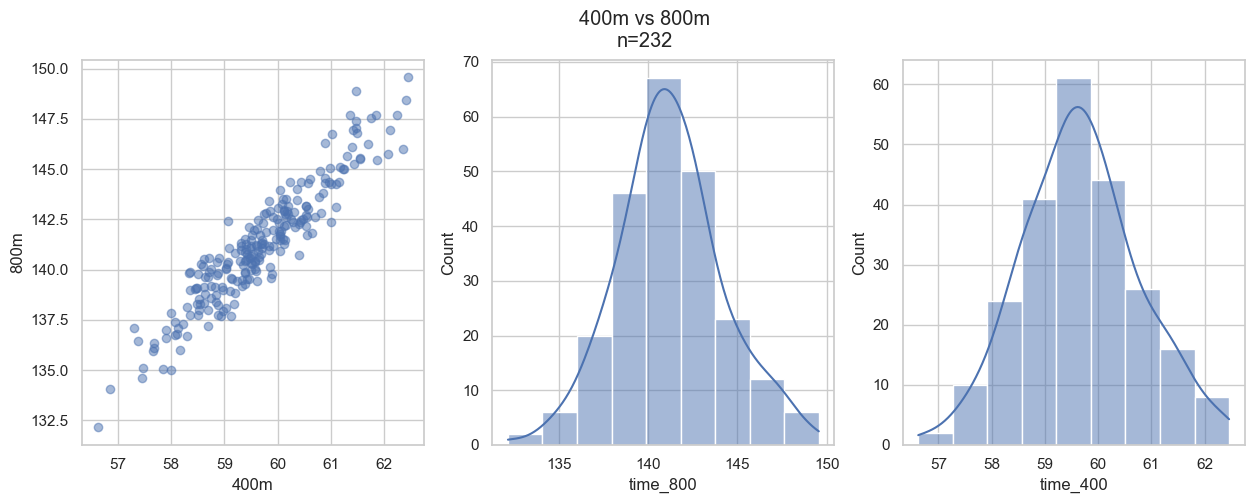

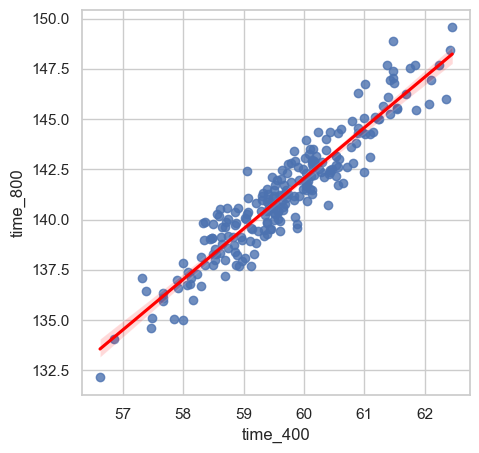

In [26]:
model_400_robust.plot_dist()
model_400_robust.check_assumptions()
model_400_robust.plot_conf_int()

In [27]:
model_400_robust.model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               time_800   No. Observations:                  232
Model:                            RLM   Df Residuals:                      230
Method:                          IRLS   Df Model:                            1
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 24 Mar 2024                                         
Time:                        21:01:53                                         
No. Iterations:                    15                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -8.6760      3.701     -2.344      0.019     -15.930      -1.421
time_400       2.5122      0.062     40.509      0.000       2.391       2.634
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

#### 800m vs 1500m

In [28]:
model_1500 = BivariateModel(df_1500_sampled, 1500, 'ols')
model_1500_robust = BivariateModel(df_1500_sampled, 1500, 'rlm')

##### OLS

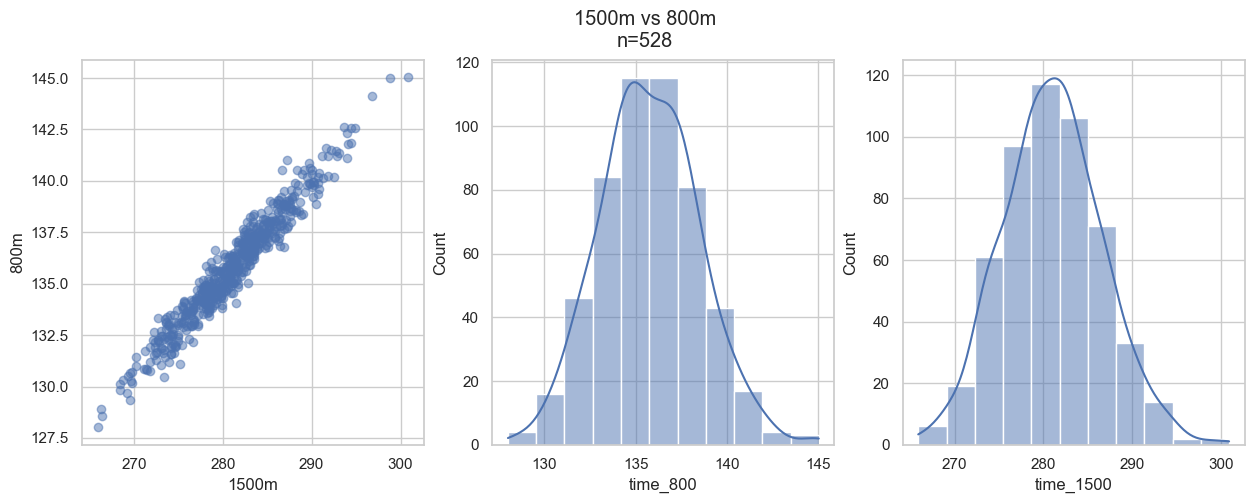

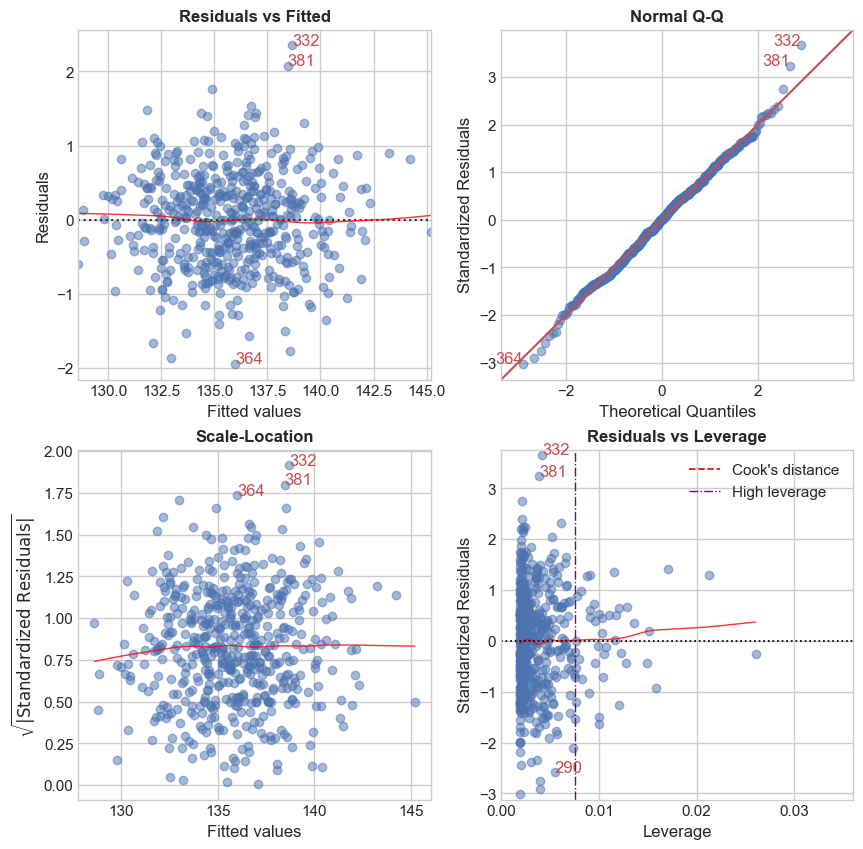

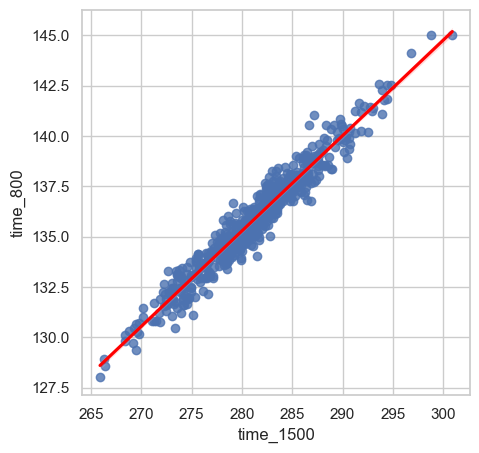

In [29]:
model_1500.plot_dist()
model_1500.check_assumptions()
model_1500.plot_conf_int()

In [30]:
model_1500.model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               time_800   R-squared:                       0.944
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     8888.
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:01:55   Log-Likelihood:                -514.65
No. Observations:                 528   AIC:                             1033.
Df Residuals:                     526   BIC:                             1042.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5908      1.413      1.834      0.067      -0.185       5.367
time_1500      0.4739      0.005     94.274      0.000       0.464       0.484
==============================================================================
Omnibus:                        0.567   Durbin-Watson:                   2.103
Prob(Omnibus):                  0.753   Jarque-Bera (JB):                0.398
Skew:                           0.034   Prob(JB):                        0.820
Kurtosis:                       3.116   Cond. No.                     1.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Robust LM

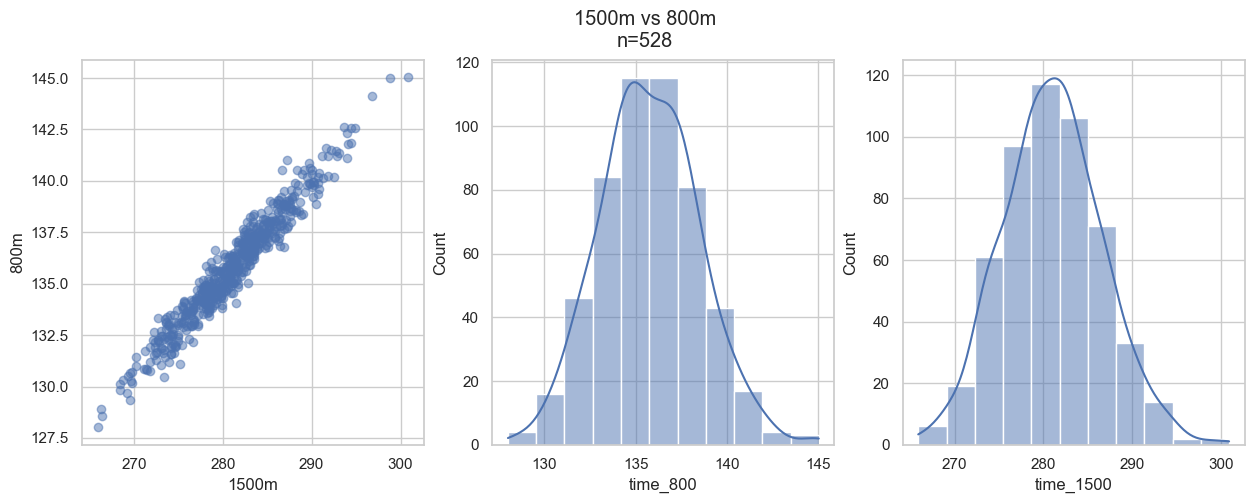

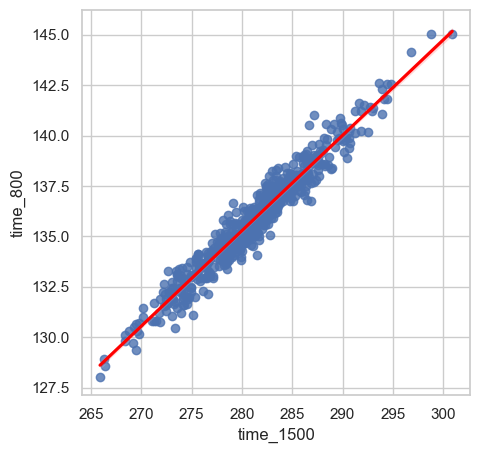

In [31]:
model_1500_robust.plot_dist()
model_1500_robust.check_assumptions()
model_1500_robust.plot_conf_int()

#### 800m vs 400m + 1500m

In [32]:
model_400_1500 = MultivariateModel(df_400_1500, model_type='ols')
model_400_1500_robust = MultivariateModel(df_400_1500, model_type='rlm')

##### OLS

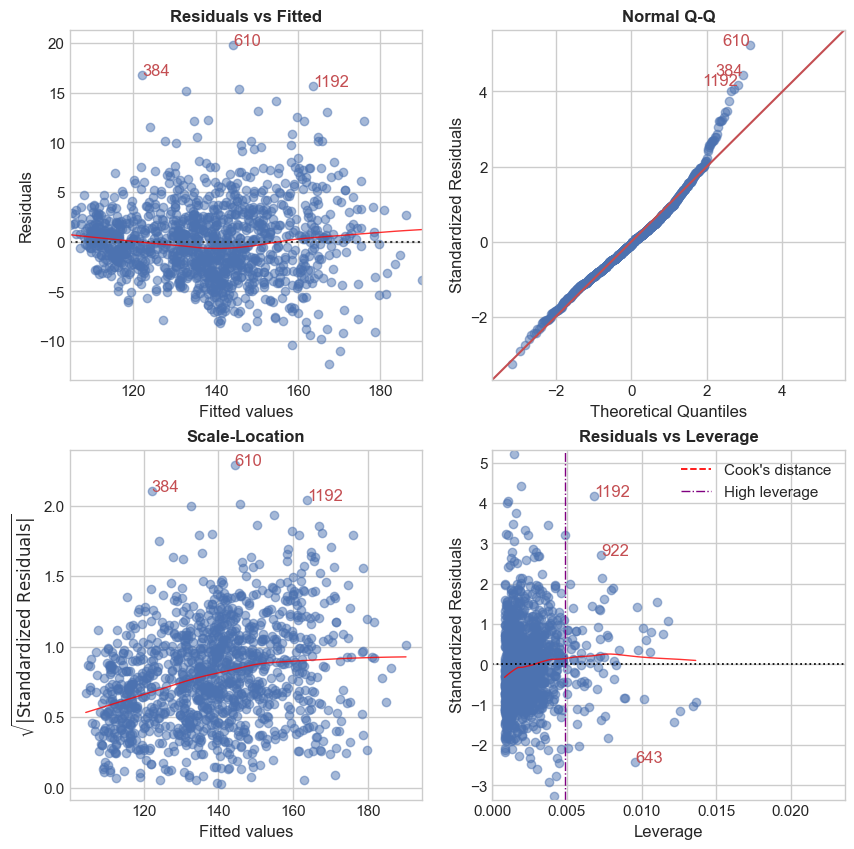

,Features,VIF Factor
1,time_400,5.86
2,time_1500,5.86
0,Intercept,86.98


In [33]:
model_400_1500.check_assumptions()[0]

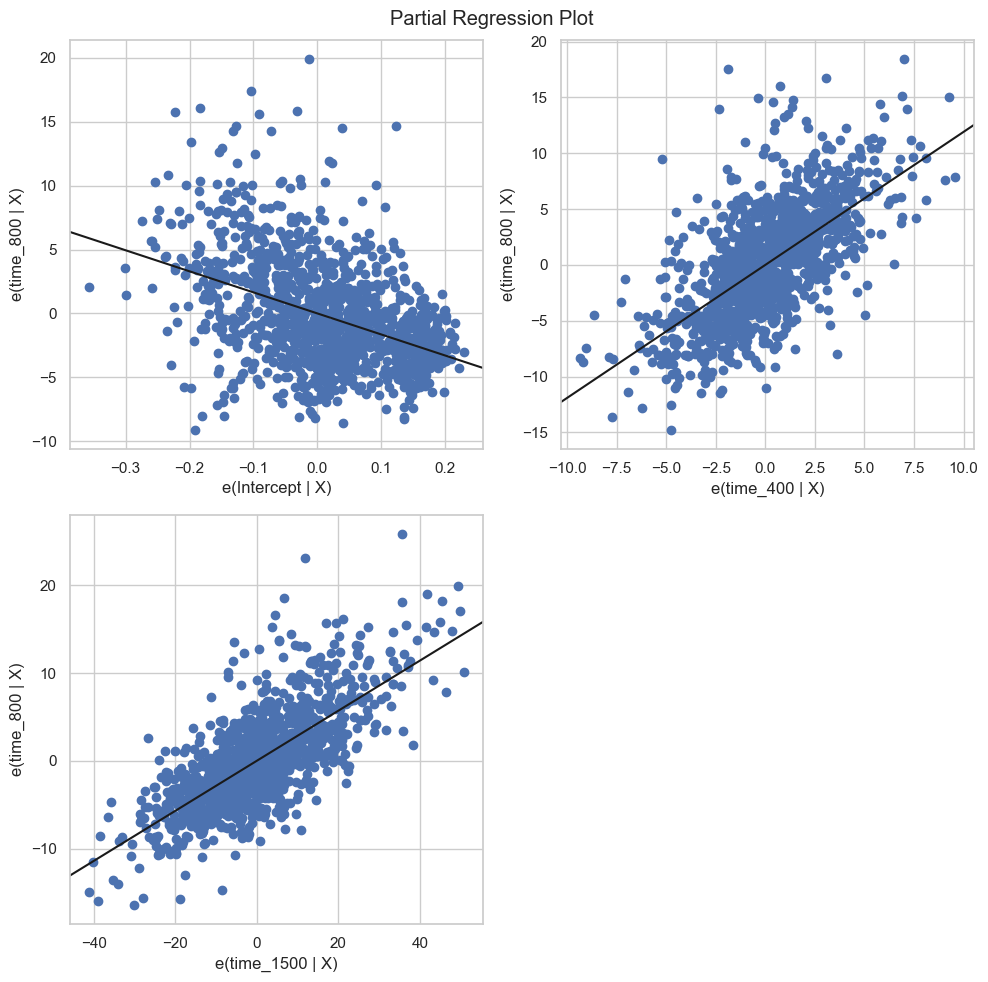

In [34]:
model_400_1500.plot_partial_regressors()

In [35]:
model_400_1500.model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               time_800   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                 1.243e+04
Date:                Sun, 24 Mar 2024   Prob (F-statistic):               0.00
Time:                        21:02:04   Log-Likelihood:                -3406.9
No. Observations:                1240   AIC:                             6820.
Df Residuals:                    1237   BIC:                             6835.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.4750      1.001    -16.455      0.000     -18.439     -14.511
time_400       1.1913      0.040     29.669      0.000       1.113       1.270
time_1500      0.2855      0.008     36.956      0.000       0.270       0.301
==============================================================================
Omnibus:                      130.405   Durbin-Watson:                   1.411
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              260.467
Skew:                           0.657   Prob(JB):                     2.76e-57
Kurtosis:                       4.821   Cond. No.                     2.79e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.79e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
model_400_1500.predict_time(times = ['0:53.80', '4:18.40'], events=[400, 1600])

'800m Prediction: 116.77 seconds'

##### Robust LM

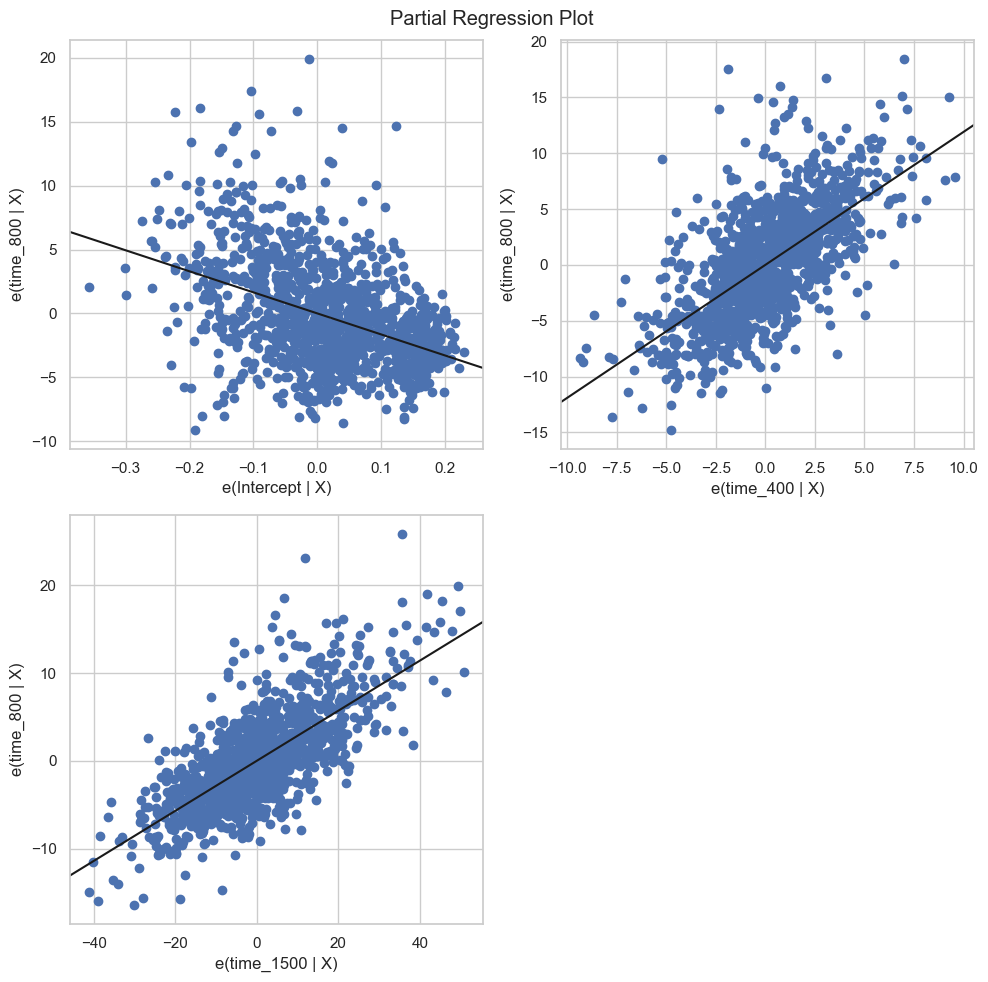

In [40]:
model_400_1500_robust.plot_partial_regressors()

In [39]:
model_400_1500_robust.model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Robust linear Model Regression Results                    
==============================================================================
Dep. Variable:               time_800   No. Observations:                 1240
Model:                            RLM   Df Residuals:                     1237
Method:                          IRLS   Df Model:                            2
Norm:                          HuberT                                         
Scale Est.:                       mad                                         
Cov Type:                          H1                                         
Date:                Sun, 24 Mar 2024                                         
Time:                        21:05:35                                         
No. Iterations:                    18                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -16.0980      0.929    -17.321      0.000     -17.920     -14.276
time_400       1.2165      0.037     32.639      0.000       1.143       1.290
time_1500      0.2784      0.007     38.820      0.000       0.264       0.292
==============================================================================

If the model instance has been used for another fit with different fit parameters, then the fit options might not be the correct ones anymore .
"""

In [38]:
model_400_1500_robust.predict_time(times = ['0:53.80', '4:18.40'], events=[400, 1600])

'800m Prediction: 116.79 seconds'

# [More diagnostics](https://www.statsmodels.org/dev/examples/notebooks/generated/regression_diagnostics.html)